In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np



In [3]:

#  Load the FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)


100%|██████████| 26421880/26421880 [00:15<00:00, 1703977.78it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 197547.13it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 640864.01it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24425652.71it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [23]:
# Define ConvModule, InceptionModule, and DownsampleModule as per your updated architecture
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        self.branch1 = ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        self.branch2 = ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
        self.branch1 = ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0)
        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

# Define InceptionSmall model
class InceptionSmall(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionSmall, self).__init__()
        self.conv1 = ConvModule(in_channels=1, out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96, f_1x1=32, f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64, f_1x1=32, f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80, f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160, f_1x1=112, f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160, f_1x1=96, f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160, f_1x1=80, f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160, f_1x1=48, f_3x3=96)
        self.down2 = DownsampleModule(in_channels=144, f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240, f_1x1=176, f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336, f_1x1=176, f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(16464, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [24]:
# List of learning rates between 1e-9 and 10
learning_rates = np.logspace(-9, 1, num=10)
train_losses = []

print(torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

True


In [25]:
!nvidia-smi

Fri Sep 27 23:05:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              32W /  70W |    437MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [26]:
for lr in learning_rates:
    # Reinitialize the model for each learning rate to ensure fairness
    model = InceptionSmall().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model for 5 epochs and calculate average training loss
    running_loss = 0.0
    for epoch in range(5):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimizer step

            running_loss += loss.item()

    # Store the average training loss after 5 epochs for each learning rate
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

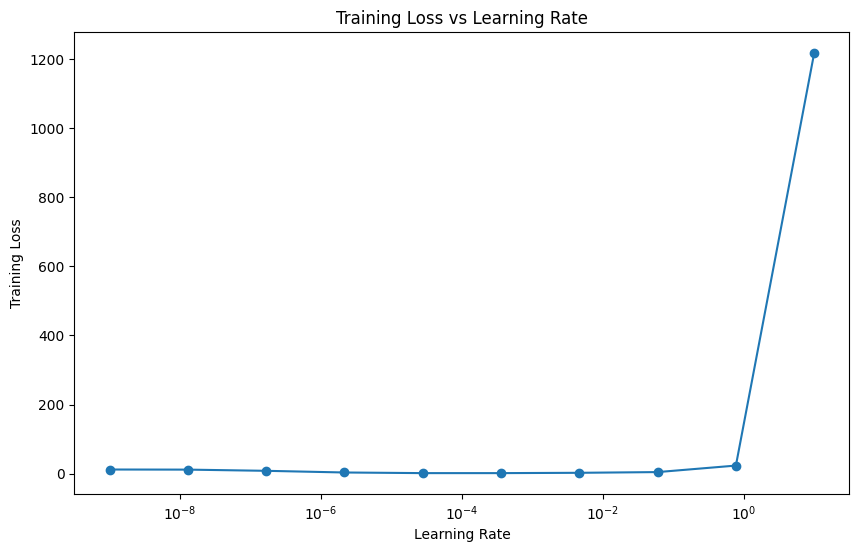

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_losses, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Learning Rate')
plt.show()